<img src='../data/imgs/udesa_logo.png'>

<h1> Notebook de analisis de modelo: ResNet50

<h2> Cargamos el modelo

In [1]:
import torch
import random
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torchvision import models, transforms
from utils_dataset import get_val_dataset_and_loader
from analisis import plot_gradcam_indices, extract_features
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

<h4> Cargo el dataset con sus respectivas transformaciones

In [2]:
imagenet_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_dataset, val_loader = get_val_dataset_and_loader(
    csv_file="../data/stanford_cars/labels_val.csv",
    img_dir="../data/stanford_cars/validation",
    transform=imagenet_transform,
)

<h4> Definir el modelo y cargar los pesos entrenados

In [3]:
num_classes = 49
model = models.resnet50(weights=None)
model.fc = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(model.fc.in_features, num_classes)
)

model.load_state_dict(torch.load("../pesos/resnet50_best_copy.pth", map_location="cpu"))
model = model.to("cpu")
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

<h4> Evaluo el modelo en el conjunto de validación

In [4]:
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        all_preds.extend(predicted.tolist())
        all_labels.extend(labels.tolist())

<h2> Analisis cuantitiativo

En primer lugar queremos hacer un analisis tradicional, cualititvio para ver los resultados generales de los modelos. Para esto vamos a ver metricas generales como la accuracy, precision, recall y f1-score, y las curvas de entrenamiento, matriz de confusion, etc.

<img src='../data/imgs/plot1.png'>

A diferencia del modelo de resnet18, el modelo de resnet50 overfitea demasiado, teniendo 99 porciento de acierto en el set de entrenamiento y 70 porciento de acierto en el set de validación. Esto es un problema, ya que el modelo no generaliza bien a datos que no ha visto antes.

In [5]:
# Primero mostramos métricas generales para todas las etiquetas
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-score'],
    'ResNet50': [accuracy, precision, recall, f1]
})
metrics_df['ResNet50'] = metrics_df['ResNet50'].round(2)
display(metrics_df)

,Metric,ResNet50
0,Accuracy,0.82
1,Precision,0.83
2,Recall,0.82
3,F1-score,0.82


Podemos ver que es un buen modelo, alcanzando el 80 porciento de acierto en el set de validacion, a grandes rasgos, le podria faltar un poquito pero parece suficientemente robusto.

In [6]:
# Mostramos las predicciones para todas las etiquetas
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.43      0.33      0.38         9
           1       0.89      0.67      0.76        51
           2       0.94      0.86      0.90        36
           3       0.93      0.90      0.91       117
           4       0.78      0.91      0.84       102
           5       0.88      0.95      0.92        40
           6       0.82      0.90      0.86        10
           7       0.81      0.79      0.80        33
           8       0.88      0.69      0.77        32
           9       0.75      0.88      0.81       181
          10       0.85      0.81      0.83        43
          11       0.90      0.82      0.86        11
          12       0.87      0.88      0.87       132
          13       0.67      0.50      0.57         8
          14       0.57      1.00      0.73         8
          15       0.94      0.78      0.85        37
          16       0.89      0.80      0.84        10
          17       0.83    

Podemos ver que es mas o meons consistente entre todas las clases, en algunas prece que tienen cerca del 50 o 40 porciento, pero la gran mayoria se mantienen alrededor del 80 porciento, lo que es un buen resultado. 

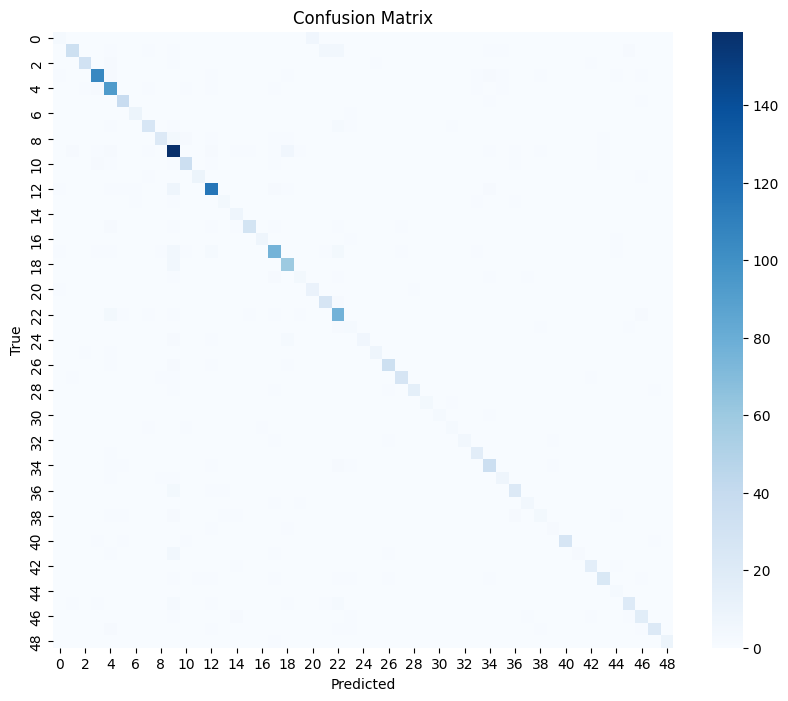

In [7]:
# Matriz de confusion
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

<h2> Analisis cualitativo de las predicciones

Esta parte es un analisi mas enfocado a como son los resultados de las preddicones en si mas alla de si estan bien o mal, sino que queremos ver como se comporta el modelo en las diferentes clases, y como se comporta en las diferentes imagenes.

En primer lugar, vamos a ver imagenes donde el modelo acierta y falla, para train y validacion, para ver si podemos tener una mejor idea de que es lo que el modelo esta aprendiendo.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


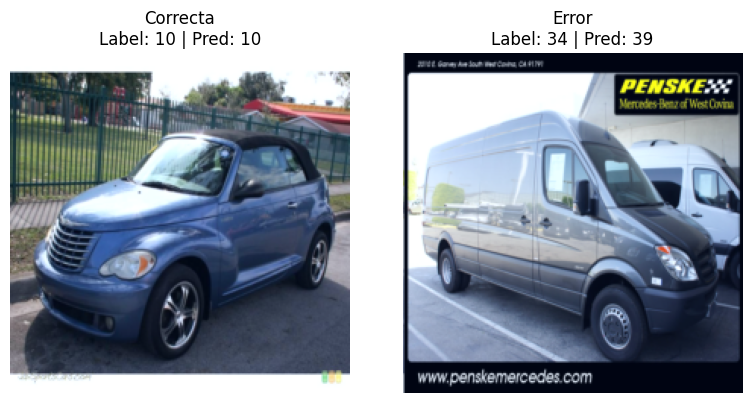

In [8]:
# Mostramos una imagen correctamente clasificada y una mal clasificada
correct_indices = [i for i, (p, l) in enumerate(zip(all_preds, all_labels)) if p == l]
incorrect_indices = [i for i, (p, l) in enumerate(zip(all_preds, all_labels)) if p != l]

idx_correct = random.choice(correct_indices)
img_correct, label_correct = val_dataset[idx_correct]
pred_correct = all_preds[idx_correct]

idx_incorrect = random.choice(incorrect_indices)
img_incorrect, label_incorrect = val_dataset[idx_incorrect]
pred_incorrect = all_preds[idx_incorrect]


fig, axs = plt.subplots(1, 2, figsize=(8, 4))

# Imagen correctamente clasificada
axs[0].imshow(img_correct.permute(1, 2, 0).numpy() * 0.229 + 0.485)  # Desnormalizar si es necesario
axs[0].set_title(f"Correcta\nLabel: {label_correct} | Pred: {pred_correct}")
axs[0].axis('off')

# Imagen mal clasificada
axs[1].imshow(img_incorrect.permute(1, 2, 0).numpy() * 0.229 + 0.485)
axs[1].set_title(f"Error\nLabel: {label_incorrect} | Pred: {pred_incorrect}")
axs[1].axis('off')

plt.tight_layout()
plt.show()

Luego, vamos a aplicar el algoritmo de Grad-CAM para ver que regiones de la imagen son las que el modelo esta usando para hacer sus predicciones.

c:\Users\03tom\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\module.py:1842: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


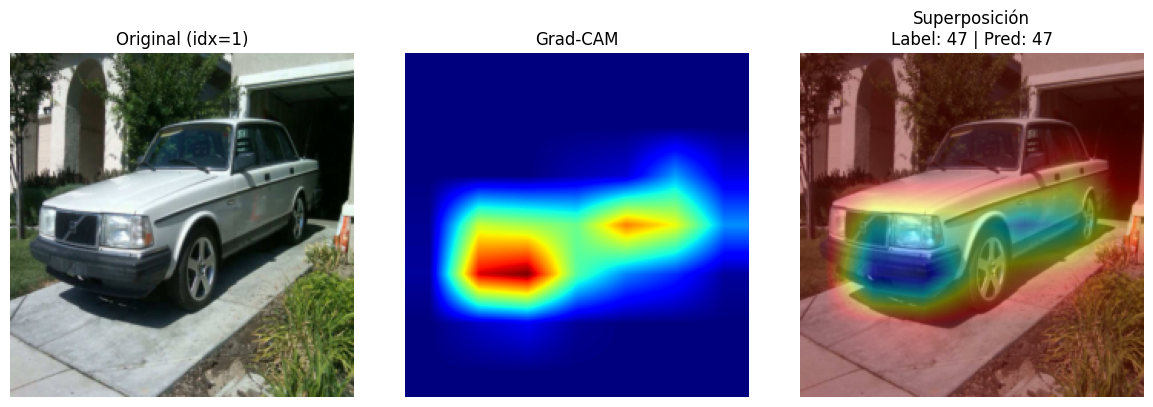

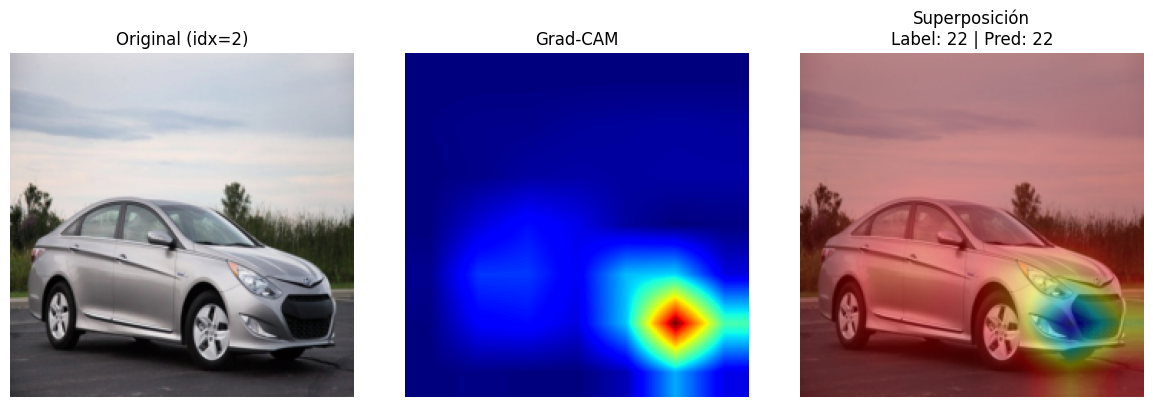

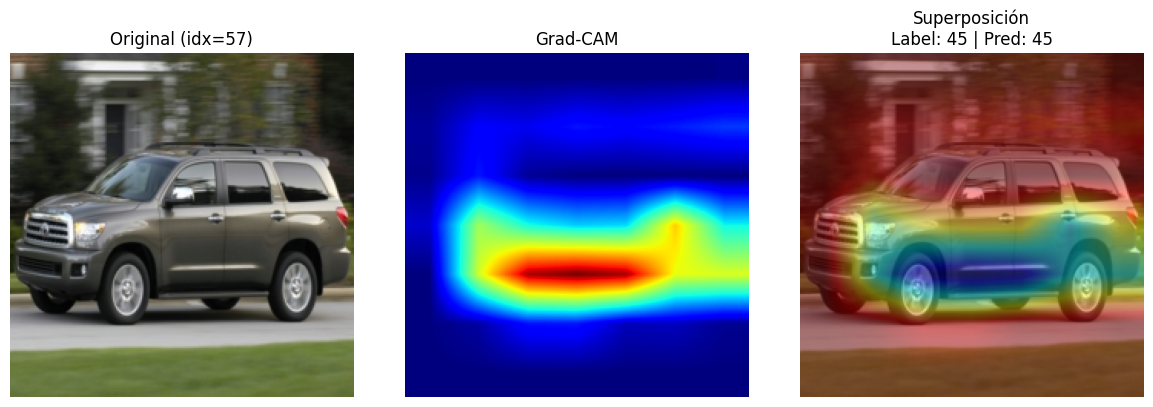

In [9]:
plot_gradcam_indices(model, val_dataset, indices=[1, 2, 57])

Por lo que podemos ver, el modelo esta capturando no solo las regiones delanteras de los autos principalmente para poder diferenciaarlos, sino que tambien utiliza un poco los costados de mismo, la parte baja de las puertas, lugares donde se puede encontrar la mayores fierencias entre modelos y marcas de autos, ya que los vidrios y las ruedas son muy similares entre todos los autos. Parece que el modelo aprende buenos lugares donde prestar atencion.

Por utlimo, queremos ver un poco las caractersiticas que extrajo para cada clase en baja dimensionalidad, para ver como se agrupan las caracteriticas de las diferentes clases, y ver si se logran separar bien y hay clusters bien definidos, o si hay clases que se mezclan entre si.

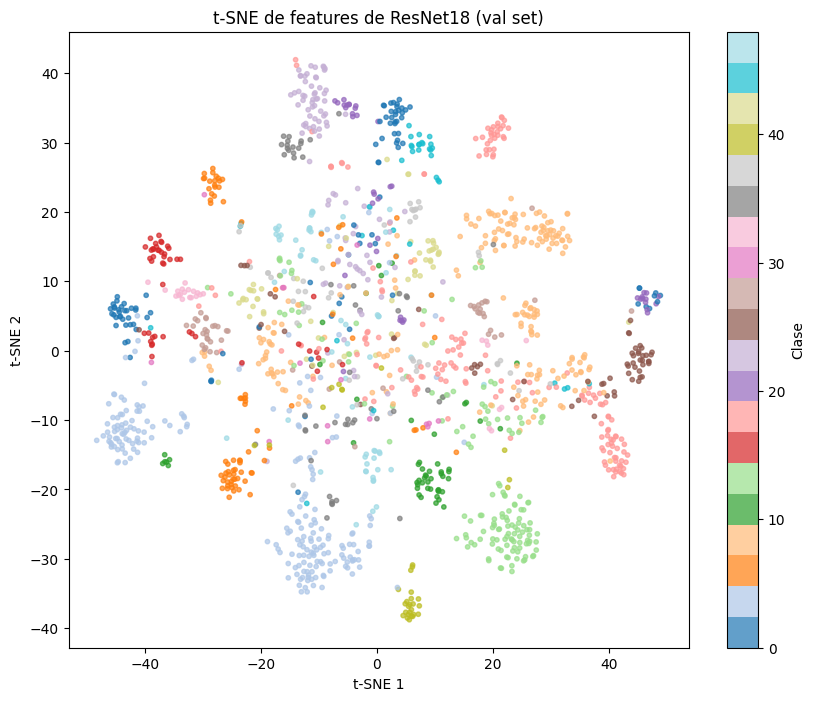

In [10]:
# Extraigo features y labels de la penultima capa (antes de clasificar)
features, labels = extract_features(model, val_loader)

# t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
features_2d = tsne.fit_transform(features)

# Graficar
plt.figure(figsize=(10, 8))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels, cmap='tab20', s=10, alpha=0.7)
plt.colorbar(scatter, label='Clase')
plt.title("t-SNE de features de ResNet18 (val set)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()

Podemos ver que hay dos tipos de caracteristicas: en primer lugar tenemos las caracterisitcas mas alejadas del orgien, estas muestran clusters muy bien definidos, cerca de su cernto de cluster, los puntos no se van muy lejos de ese centro, y no parece que intrerfieran puntos de otra clase dentro.

Por otro lado, tenemos las caracteristicas mas cercanas al origen, estas muestran clusters mas difusos, donde los puntos se mezclan entre si, y no hay un centro de cluster bien definido. Esto puede ser un problema, ya que el modelo puede confundirse entre estas clases y no ser capaz de diferenciarlas bien.

In [11]:
np.savez("../data/pred/predicciones_resnet50.npz", preds=all_preds, labels=all_labels)